In [1]:
import os
import time
from sklearn.preprocessing import MinMaxScaler
import random
import numpy as np
import pandas as pd
from collections import deque
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, CuDNNLSTM
from keras.optimizers import Adam
from keras import backend as K
import time as t_lib
import tensorflow as tf
from threading import Thread
from IPython.display import clear_output
from matplotlib import pyplot

Using TensorFlow backend.


In [2]:
DATAFRAME_NAME = 'EURUSD_m15_Ask_ready.csv'
NUMBER_OF_SAMPLES = 50

EPISODES = 5000
TICQTY_MAX = 55000
HOLD_REWARD = -5000
OPEN_TRADE_REWARD = 0
CLOSING_TRADE_WITH_OPENING = 100  #20
DIVIDE_PRICE_UNDER_LOCAL_MINIMA = 1  #10
REWARD_FOR_PIPS = 10000
TIMES_FACTOR = 40 #10

ACTION_DECODE = {
    0: 0,
    1: 0.5,
    2: 1,
}


In [3]:
class Dataframe:

    def __init__(self):
        self._dataframe = self._load()[0:2000]
        self.__scaler = MinMaxScaler()

    @property
    def lenght(self):
        return len(self._dataframe.index) - NUMBER_OF_SAMPLES

    def get(self, sample_number):
        if sample_number > self.lenght or sample_number < 0:
            raise ValueError("Sample number out of range (0 - {self.lenght})")

        start_index = sample_number
        end_index = start_index + NUMBER_OF_SAMPLES

        df_sample = self._dataframe[start_index: end_index]

        last_open = df_sample.at[df_sample.index[-1], 'open']
        last_close = df_sample.at[df_sample.index[-1], 'close']

        df_sample = df_sample[['open', 'close', 'high', 'low', 'tickqty', 'hours', 'minutes']].values
        df_sample = self._scale(df_sample, start=0, end=4)
        return np.expand_dims(df_sample, axis=0), last_open, last_close

    @staticmethod
    def _load():
        """ Creating relative path and then loading the df_path """
        """
        df_path = os.path.join(os.path.dirname(os.path.abspath(__file__)) +
                               os.path.normpath(f'/dfs/{cfg.DATAFRAME_NAME}'))
        """
        df_path = './dfs/{}'.format(DATAFRAME_NAME)
        df = pd.read_csv(
            df_path,
            dtype={
                'datetime'
                'open': np.float32,
                'close': np.float32,
                'high': np.float32,
                'low': np.float32,
                'tickqty': np.float32,
            }
        )

        # df['hours']= pd.to_datetime(df['datetime'], format='%Y%m%d %H:%M:%S.%f').dt.hour / 24
        df['hours'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.hour / 24
        df['minutes'] = pd.to_datetime(df['date'], format='%m-%d-%Y %H:%M:%S').dt.minute / 64
        df['tickqty'] = df['tickqty'] / TICQTY_MAX
        return df

    def _scale(self, array: np.ndarray, start: int, end: int):
        columns = array.T[start: end].T

        self.__scaler.fit(columns)
        scaled_cols = self.__scaler.transform(columns).T
        array.T[start:end] = scaled_cols
        return array

In [ ]:
class DQNAgent:
    def __init__(self, state_size, action_size, batch_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = deque(maxlen=20000)
        self.sample_memory = deque()
        
        self.gamma = 0.99  # discount rate
        
        self.epsilon = 0 #0.3239 # exploration rate
        self.epsilon_min = 0.0
        self.epsilon_decay = 0.996
        
        self.learning_rate = 0.0009975
        self.learning_rate_decay = 0.99999
        self.learning_rate_min = 0.0001
        
        self.batch_size_samples = 500
        self.batch_size = batch_size
        
        self.model = self._build_model()
        self.target_model = self._build_model()
        self.update_target_model()

    """Huber loss for Q Learning

    References: https://en.wikipedia.org/wiki/Huber_loss
                https://www.tensorflow.org/api_docs/python/tf/losses/huber_loss
    """

    def _huber_loss(self, y_true, y_pred, clip_delta=1.0):
        error = y_true - y_pred
        cond = K.abs(error) <= clip_delta

        squared_loss = 0.5 * K.square(error)
        quadratic_loss = 0.5 * K.square(clip_delta) + clip_delta * (K.abs(error) - clip_delta)

        return K.mean(tf.where(cond, squared_loss, quadratic_loss))

    def _build_model(self):
        # Neural Net for Deep-Q learning Model
        model = Sequential()
        model.add(CuDNNLSTM(units=50, return_sequences=True, input_shape=self.state_size))
        model.add(CuDNNLSTM(units=33, return_sequences=True))  
        model.add(CuDNNLSTM(units=22, return_sequences=True))
        model.add(CuDNNLSTM(units=15, return_sequences=True))
        model.add(CuDNNLSTM(units=10, return_sequences=True))
        model.add(CuDNNLSTM(units=7, return_sequences=True))
        model.add(CuDNNLSTM(units=5, return_sequences=True))
        model.add(CuDNNLSTM(units=3, return_sequences=False))

        model.add(Dense(self.action_size, activation='linear'))
        model.compile(loss=self._huber_loss,
                      optimizer=Adam(lr=self.learning_rate))
        return model

    def update_target_model(self):
        # copy weights from model to target_model
        self.target_model.set_weights(self.model.get_weights())

    def memorize(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        self.sample_memory.append((state, action, reward, next_state, done))
    
    def train_from_iterations(self):
        while True:
            if len(self.sample_memory) != 0:
                state, action, reward, next_state, done = self.sample_memory.popleft()
                self.train(state, action, reward, next_state, done)

    def train(self, state, action, reward, next_state, done):
        target = self.model.predict(state, steps=1, verbose=0)
        if done and reward > 80 * TIMES_FACTOR:
            target[0][action] = reward
        else:
            # a = self.model.predict(next_state)[0]
            t = self.target_model.predict(next_state)[0]
            target[0][action] = reward + self.gamma * np.amax(t)
            # target[0][action] = reward + self.gamma * t[np.argmax(a)]
        self.model.fit(state, target, epochs=1, verbose=0)
        # print('done')

    def act(self, state):
        if not isinstance(state, np.ndarray):
            return 0

        if np.random.rand() <= self.epsilon:
            return random.randrange(self.action_size), True
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0]), False  # returns action

    def predict(self, state):
        act_values = self.model.predict(state, steps=1)
        return np.argmax(act_values[0])  # returns action

    def replay(self):
        while True:
            minibatch = random.sample(self.memory, self.batch_size)
            for state, action, reward, next_state, done in minibatch:
                if not isinstance(state, np.ndarray):
                    continue
                
                self.train(state, action, reward, next_state, done)
                """
                target = self.model.predict(state, steps=1, verbose=0)
                if done and reward > 80 * TIMES_FACTOR:
                    target[0][action] = reward
                else:
                    # a = self.model.predict(next_state)[0]
                    t = self.target_model.predict(next_state)[0]
                    target[0][action] = reward + self.gamma * np.amax(t)
                    # target[0][action] = reward + self.gamma * t[np.argmax(a)]
                self.model.fit(state, target, epochs=1, verbose=0)
                """
            if self.epsilon > self.epsilon_min:
                self.epsilon *= self.epsilon_decay
            else:
                self.epsilon = self.epsilon_min
            
            if self.learning_rate > self.learning_rate_min:
                self.learning_rate *= self.learning_rate_decay
            else:
                self.learning_rate = self.learning_rate_min
            # print('done')
    
    def set_learning_rate(self):
        K.set_value(self.model.optimizer.lr, self.learning_rate)  # set new lr
        K.set_value(self.target_model.optimizer.lr, self.learning_rate)  # set new lr

    def load(self, name):
        self.model.load_weights(name)
        self.model._make_predict_function()
        self.model._make_test_function()
        self.model._make_train_function()

        self.target_model.load_weights(name)
        self.target_model._make_predict_function()
        self.target_model._make_test_function()
        self.target_model._make_train_function()

    def save(self, name):
        self.model.save_weights(name)

In [ ]:
class Trevor:
    POSITIVE_TIMES_REWARD = 0.00001
    NEGATIVE_TIMES_REWARD = 0.00001

    def __init__(self, df):
        self.df = df

        self.cursor = 0
        self.enter_price = 0
        self.local_max_price = 0

        self.last_action = 0

        self.closed_counter = 0
        self.total_reward = 0
        self.trade_counter = 0

        self.closed_counter_list = []

    def reset(self):
        self.cursor = 0
        self.enter_price = 0
        self.last_action = 0
        self.closed_counter = 0
        self.trade_counter = 0
        self.total_reward = 0
        # self.reset_closed_list()

        return self.step(0)[0]

    def step(self, action):
        sample, last_open, last_close = self.df.get(self.cursor)

        reward, closing_trade = self.__process_action(action=action, last_close=last_close)
        sample = self.__append_last_action(sample=sample, action=action, last_close=last_close)

        self.__increment_cursor()

        return sample, reward, closing_trade, ''

    def get_total_reward(self):
        return self.total_reward

    def reset_closed_list(self):
        self.closed_counter_list = []

    def plot(self, title):
        x = list(range(1, len(self.closed_counter_list) + 1))
        pyplot.plot(x, self.closed_counter_list)
        pyplot.title(str(title))
        pyplot.show()

    def __process_action(self, action, last_close):
        if action < 0 or action > 2:
            raise ValueError('Action have to be inrage (0 - 2) got {action}')

        closing_trade = False

        # """ CLOSING POSITION """
        if (self.last_action == 2 and action == 0) or (self.last_action == 1 and action == 0):
            reward = self.__close_trade(last_close=last_close)
            closing_trade = True

        # """ CLOSING POSITION AND GOING TO DIFFERENT POSITION """
        elif (self.last_action == 2 and action == 1) or (self.last_action == 1 and action == 2):
            reward = self.__close_trade(last_close=last_close) - CLOSING_TRADE_WITH_OPENING
            self.enter_price = last_close
            self.local_max_price = last_close
            closing_trade = True

        # """ HOLDING OPENED POSITION  """
        elif (self.last_action == 2 and action == 2) or (self.last_action == 1 and action == 1):
            if self.last_action == 2:
                if self.local_max_price < last_close:
                    reward = (last_close - self.enter_price) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (last_close - self.local_max_price) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close > self.enter_price \
                        else reward

            else:
                if self.local_max_price > last_close:
                    reward = (self.enter_price - last_close) * REWARD_FOR_PIPS
                    self.local_max_price = last_close

                else:
                    reward = (self.local_max_price - last_close) * REWARD_FOR_PIPS
                    reward = reward / DIVIDE_PRICE_UNDER_LOCAL_MINIMA if last_close < self.enter_price \
                        else reward

        # """ OPENING POSITION  """
        elif (self.last_action == 0 and action == 1) or (self.last_action == 0 and action == 2):
            self.enter_price = last_close
            self.local_max_price = last_close
            reward = OPEN_TRADE_REWARD

        # """ HOLD """
        elif self.last_action == 0 and action == 0:
            reward = HOLD_REWARD

        else:
            raise ValueError('Last action = {self.last_action} and actual_action = {action}')

        self.last_action = action
        self.total_reward += reward
        return reward, closing_trade

    def __increment_cursor(self):
        """ Incrementing the cursor, if the cursor is bigger than lenght of the dataframe, then reset it"""

        self.cursor += 1
        if self.cursor > self.df.lenght:
            self.cursor = 0

    def __close_trade(self, last_close):
        if self.last_action == 2:
            reward = (last_close - self.enter_price) * REWARD_FOR_PIPS * TIMES_FACTOR
            self.closed_counter += reward / TIMES_FACTOR
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        else:
            reward = (self.enter_price - last_close) * REWARD_FOR_PIPS * TIMES_FACTOR
            self.closed_counter += reward / TIMES_FACTOR
            reward += self.POSITIVE_TIMES_REWARD * pow(reward, 3) if reward > 0 \
                else self.NEGATIVE_TIMES_REWARD * pow(reward, 3)

        self.closed_counter_list.append(self.closed_counter)
        self.trade_counter += 1
        return reward

    def __append_last_action(self, sample: np.ndarray, action: int, last_close: float):
        how_many = sample.shape[1]
        decoded_action = ACTION_DECODE[action]

        action_arr = (np.expand_dims(np.asarray([decoded_action for i in range(0, how_many)]), axis=1))

        if action == 2 or action == 1:
            dif = (last_close - self.enter_price)
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        else:
            dif = 0
            pip_difference = (np.expand_dims(np.asarray([dif for i in range(0, how_many)]), axis=1))

        sample = np.append(sample[0], action_arr, axis=1)
        sample = np.append(sample, pip_difference, axis=1)

        return np.expand_dims(sample, axis=0)

C:\Users\Lukas\Anaconda3\lib\site-packages\dask\config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
More than 80 on candle 184
More than 80 on candle 811
More than 80 on candle 1333


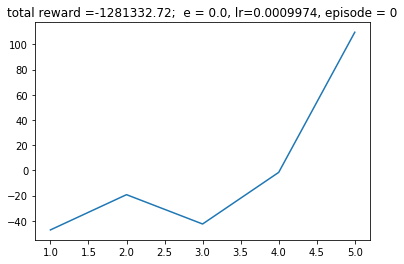

Waiting to train the whole dataset
DONE, lets roll!!
169.949
More than 80 on candle 219
More than 80 on candle 1266
More than 80 on candle 1930


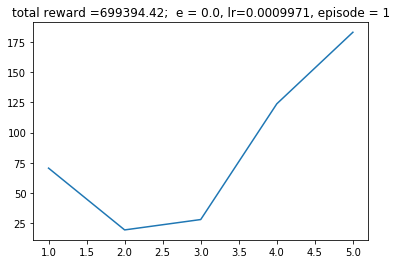

Waiting to train the whole dataset
DONE, lets roll!!
151.801


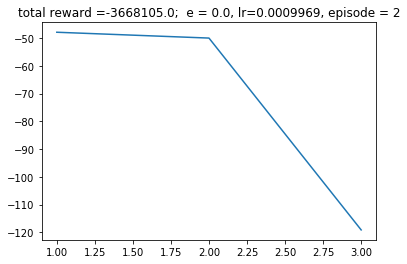

Waiting to train the whole dataset
DONE, lets roll!!
151.03
More than 80 on candle 1043
More than 80 on candle 1393


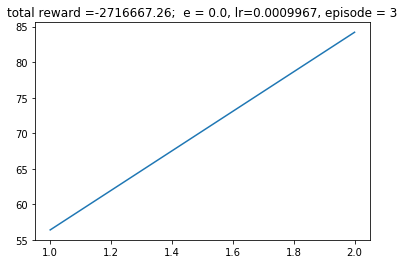

Waiting to train the whole dataset
DONE, lets roll!!
151.724
More than 80 on candle 356


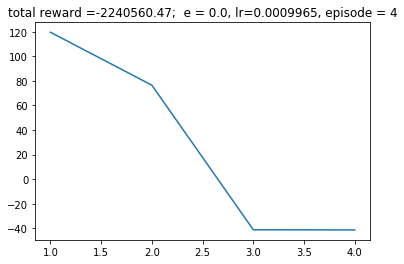

Waiting to train the whole dataset
DONE, lets roll!!
154.716
More than 80 on candle 591
More than 80 on candle 889


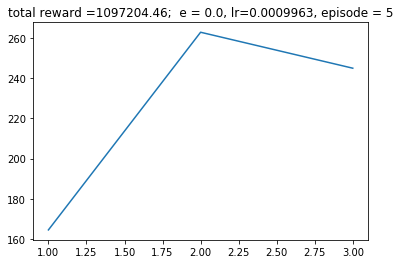

Waiting to train the whole dataset
DONE, lets roll!!
152.514
More than 80 on candle 811
More than 80 on candle 1340


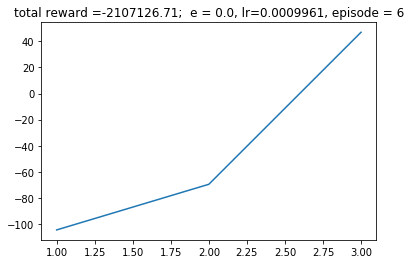

Waiting to train the whole dataset
DONE, lets roll!!
167.744
More than 80 on candle 350
More than 80 on candle 1298


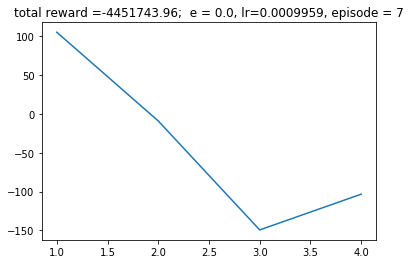

Waiting to train the whole dataset
DONE, lets roll!!
166.483
More than 80 on candle 262
More than 80 on candle 814
More than 80 on candle 1198


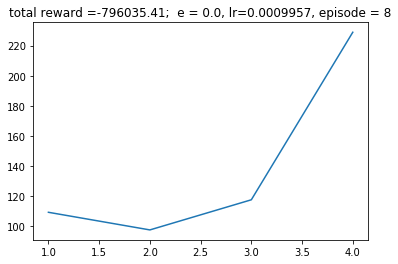

Waiting to train the whole dataset
DONE, lets roll!!
169.689
More than 80 on candle 216
More than 80 on candle 609
More than 80 on candle 1253
More than 80 on candle 1909


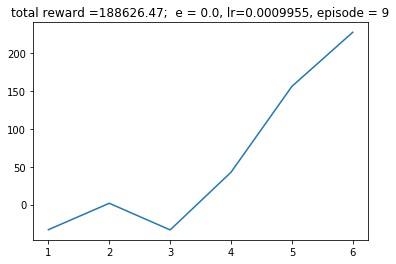

Waiting to train the whole dataset
DONE, lets roll!!
163.063
More than 80 on candle 1586


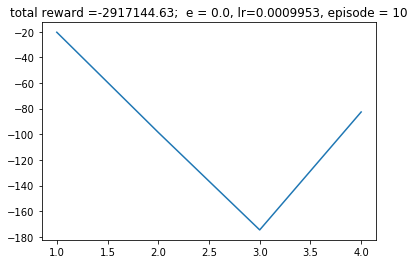

Waiting to train the whole dataset
DONE, lets roll!!
153.203
More than 80 on candle 118
More than 80 on candle 475
More than 80 on candle 666


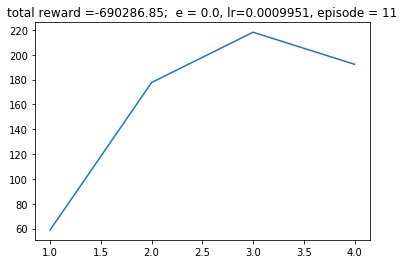

Waiting to train the whole dataset
DONE, lets roll!!
152.3
More than 80 on candle 494
More than 80 on candle 999


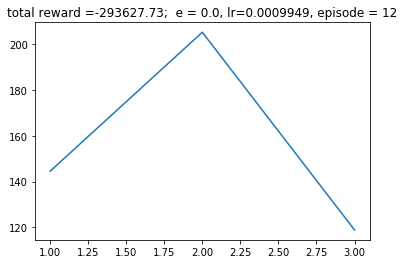

Waiting to train the whole dataset
DONE, lets roll!!
152.014
More than 80 on candle 573
More than 80 on candle 822
More than 80 on candle 1673


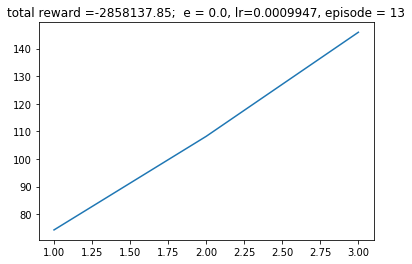

Waiting to train the whole dataset
DONE, lets roll!!
153.142
More than 80 on candle 735
More than 80 on candle 1028


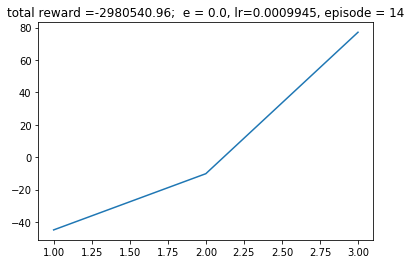

Waiting to train the whole dataset
DONE, lets roll!!
151.67
More than 80 on candle 569
More than 80 on candle 1134
More than 80 on candle 1694


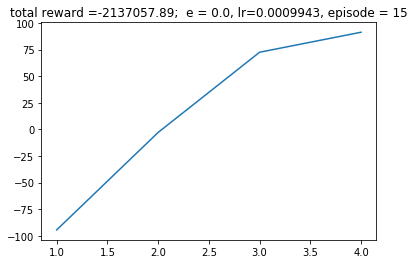

Waiting to train the whole dataset
DONE, lets roll!!
151.661
More than 80 on candle 517
More than 80 on candle 968


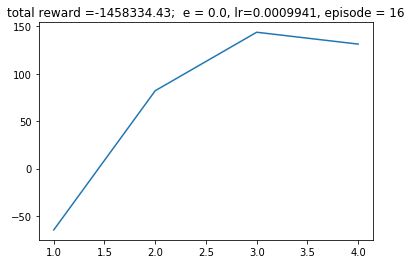

Waiting to train the whole dataset
DONE, lets roll!!
152.628
More than 80 on candle 527
More than 80 on candle 952


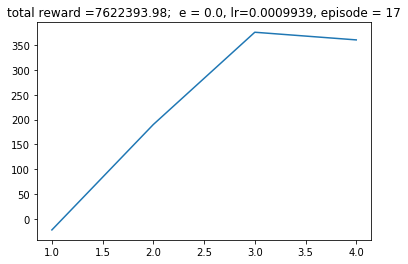

Waiting to train the whole dataset
DONE, lets roll!!
152.123
More than 80 on candle 610
More than 80 on candle 1020


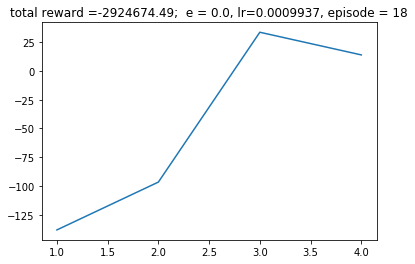

Waiting to train the whole dataset
DONE, lets roll!!
151.126
More than 80 on candle 617
More than 80 on candle 1097
More than 80 on candle 1455


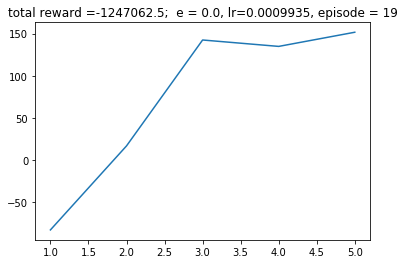

Waiting to train the whole dataset
DONE, lets roll!!
151.843
More than 80 on candle 126
More than 80 on candle 572
More than 80 on candle 871


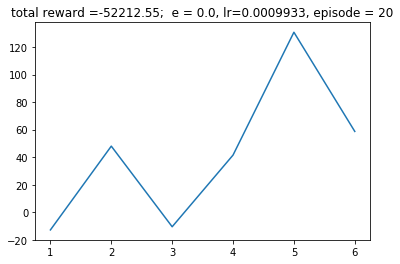

Waiting to train the whole dataset
DONE, lets roll!!
152.471
More than 80 on candle 533


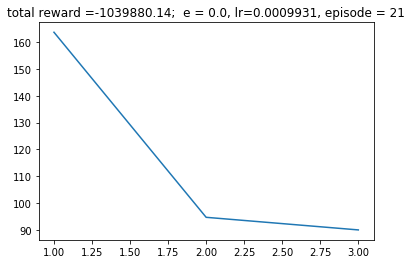

Waiting to train the whole dataset
DONE, lets roll!!
151.792
More than 80 on candle 802
More than 80 on candle 1186


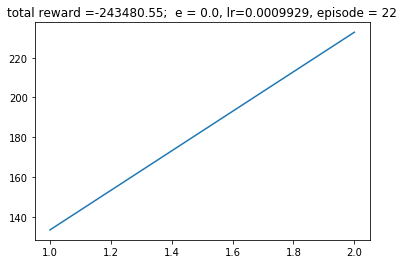

Waiting to train the whole dataset
DONE, lets roll!!
151.695
More than 80 on candle 269
More than 80 on candle 782
More than 80 on candle 1175


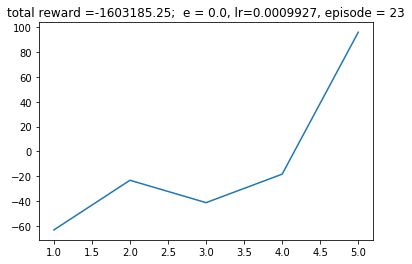

Waiting to train the whole dataset
DONE, lets roll!!
152.78
More than 80 on candle 568
More than 80 on candle 980


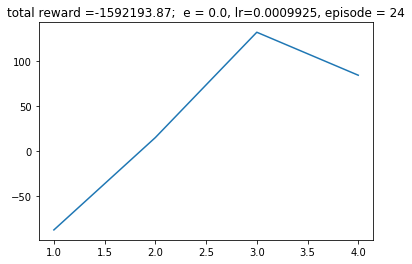

Waiting to train the whole dataset
DONE, lets roll!!
153.408
More than 80 on candle 295
More than 80 on candle 1293
More than 80 on candle 1786


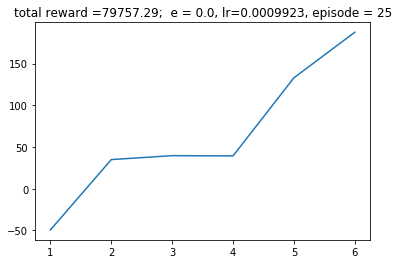

Waiting to train the whole dataset
DONE, lets roll!!
150.118
More than 80 on candle 140
More than 80 on candle 1051


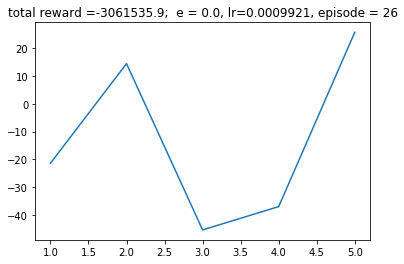

Waiting to train the whole dataset
DONE, lets roll!!
150.219
More than 80 on candle 575
More than 80 on candle 734
More than 80 on candle 1417


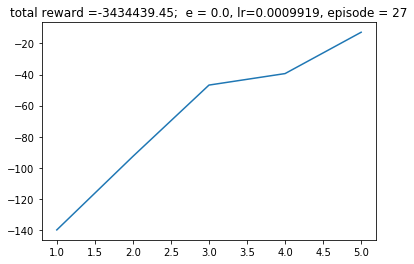

Waiting to train the whole dataset
DONE, lets roll!!
150.609
More than 80 on candle 801
More than 80 on candle 1075


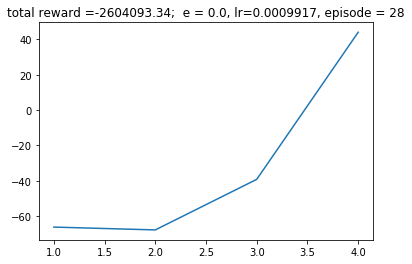

Waiting to train the whole dataset
DONE, lets roll!!
218.383
More than 80 on candle 543
More than 80 on candle 1189


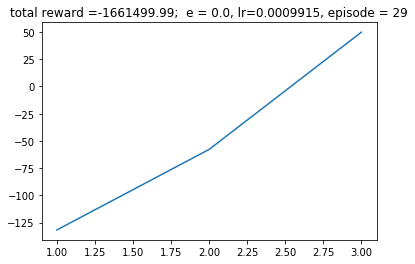

Waiting to train the whole dataset
DONE, lets roll!!
152.458
More than 80 on candle 949


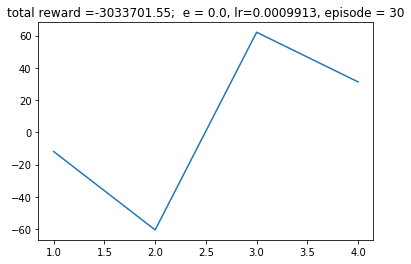

Waiting to train the whole dataset
DONE, lets roll!!
150.748
More than 80 on candle 661
More than 80 on candle 1087


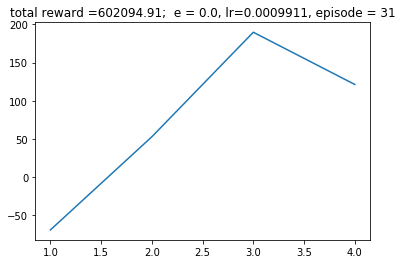

Waiting to train the whole dataset
DONE, lets roll!!
150.843
More than 80 on candle 599
More than 80 on candle 709
More than 80 on candle 1357


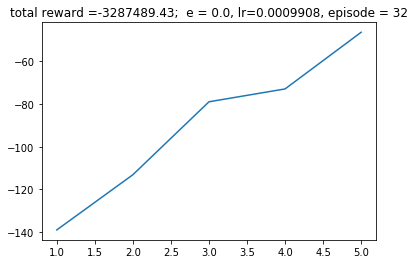

Waiting to train the whole dataset
DONE, lets roll!!
151.036
More than 80 on candle 1626


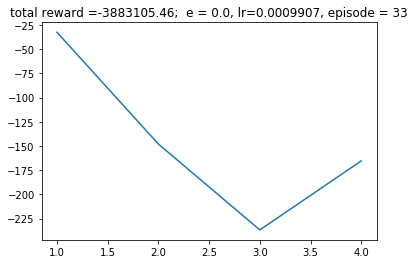

Waiting to train the whole dataset
DONE, lets roll!!
150.279
More than 80 on candle 256


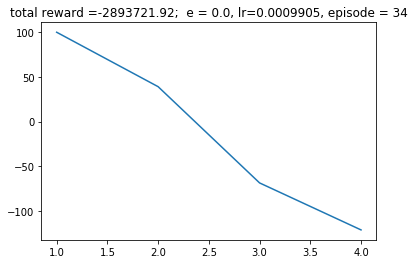

Waiting to train the whole dataset
DONE, lets roll!!
150.653
More than 80 on candle 934


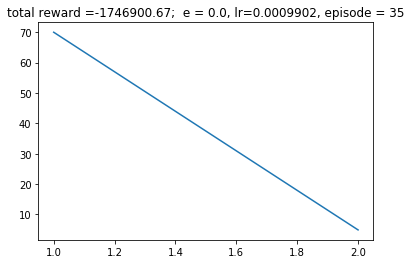

Waiting to train the whole dataset
DONE, lets roll!!
151.123
More than 80 on candle 637


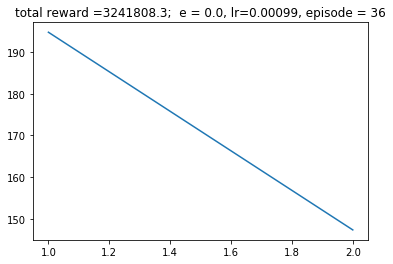

Waiting to train the whole dataset
DONE, lets roll!!
151.129
More than 80 on candle 235


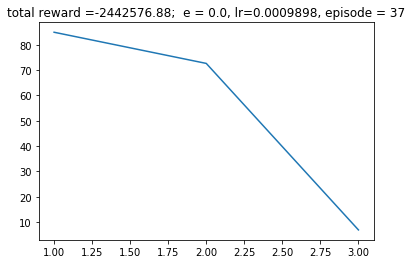

Waiting to train the whole dataset
DONE, lets roll!!
150.541
More than 80 on candle 892


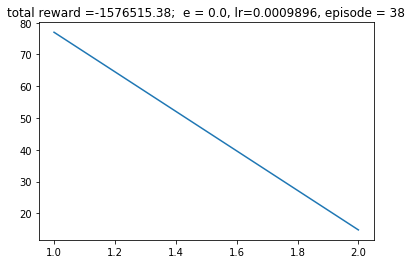

Waiting to train the whole dataset
DONE, lets roll!!
153.313
More than 80 on candle 764
More than 80 on candle 1595


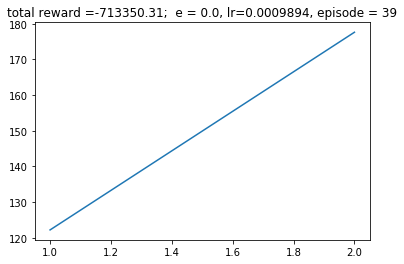

Waiting to train the whole dataset
DONE, lets roll!!
162.4
More than 80 on candle 559
More than 80 on candle 1090
More than 80 on candle 1736


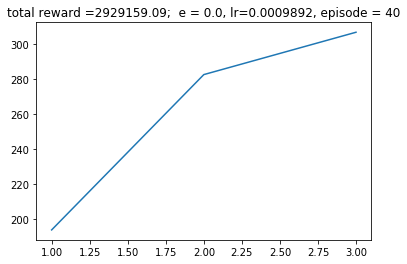

Waiting to train the whole dataset
DONE, lets roll!!
153.678
More than 80 on candle 537
More than 80 on candle 793


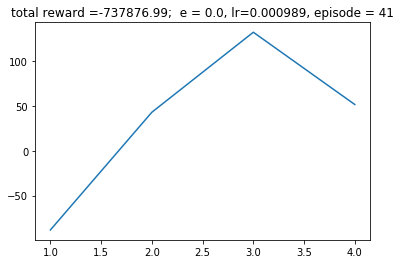

Waiting to train the whole dataset
DONE, lets roll!!
153.16
More than 80 on candle 188
More than 80 on candle 524
More than 80 on candle 824


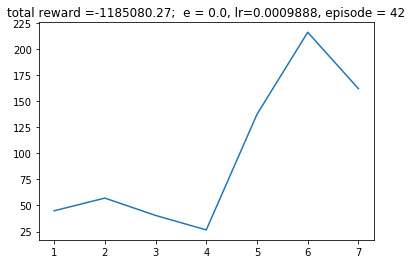

Waiting to train the whole dataset
DONE, lets roll!!
153.107
More than 80 on candle 550
More than 80 on candle 830
More than 80 on candle 1664


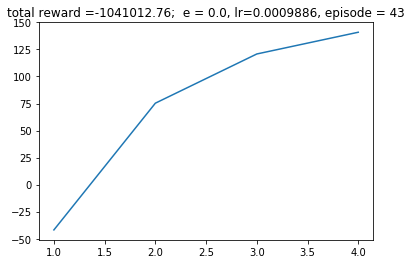

Waiting to train the whole dataset
DONE, lets roll!!
151.877
More than 80 on candle 804
More than 80 on candle 1165


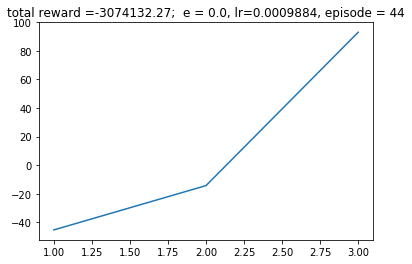

Waiting to train the whole dataset
DONE, lets roll!!
151.207
More than 80 on candle 560
More than 80 on candle 886


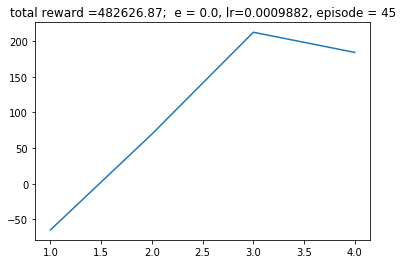

Waiting to train the whole dataset
DONE, lets roll!!
152.167
More than 80 on candle 537
More than 80 on candle 859


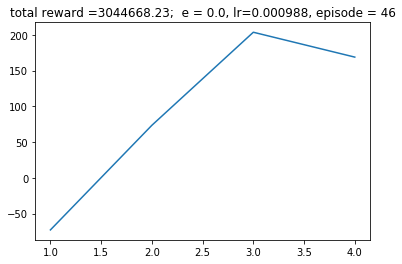

Waiting to train the whole dataset
DONE, lets roll!!
151.611
More than 80 on candle 566
More than 80 on candle 833
More than 80 on candle 1747


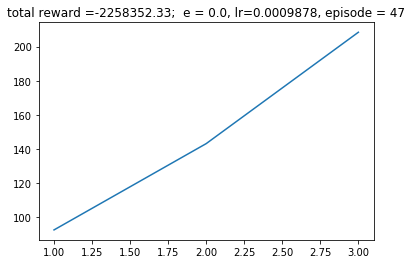

Waiting to train the whole dataset
DONE, lets roll!!
151.181


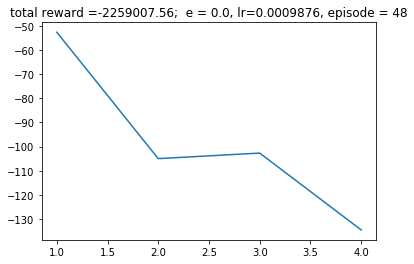

Waiting to train the whole dataset
DONE, lets roll!!
151.589
More than 80 on candle 744
More than 80 on candle 1402


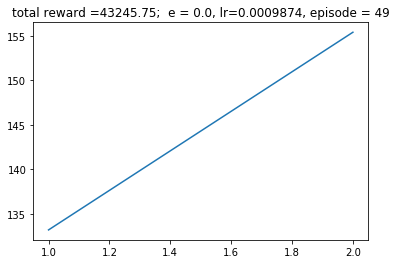

Waiting to train the whole dataset
DONE, lets roll!!
153.262
More than 80 on candle 571
More than 80 on candle 1188
More than 80 on candle 1812


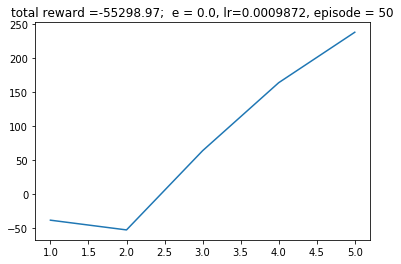

Waiting to train the whole dataset
DONE, lets roll!!
151.727
More than 80 on candle 526
More than 80 on candle 947


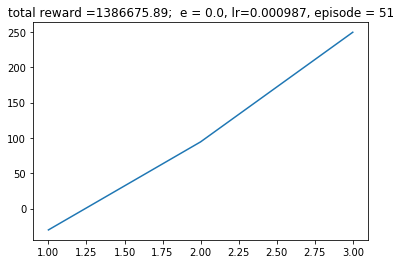

Waiting to train the whole dataset
DONE, lets roll!!
151.361
More than 80 on candle 517
More than 80 on candle 1034
More than 80 on candle 1746


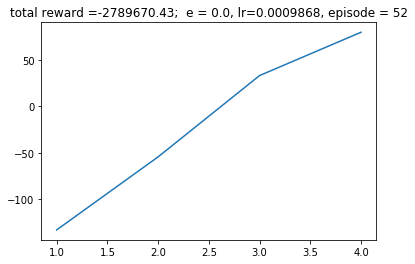

Waiting to train the whole dataset
DONE, lets roll!!
152.468
More than 80 on candle 475
More than 80 on candle 1024
More than 80 on candle 1671


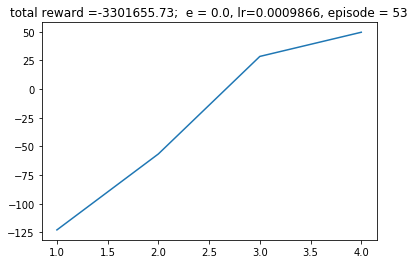

Waiting to train the whole dataset
DONE, lets roll!!
151.775
More than 80 on candle 504
More than 80 on candle 588
More than 80 on candle 681
More than 80 on candle 1907


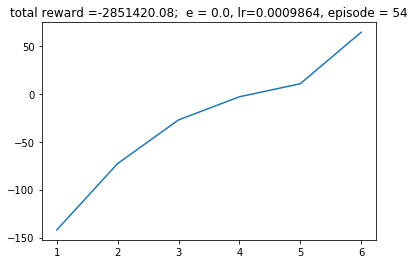

Waiting to train the whole dataset
DONE, lets roll!!
153.997
More than 80 on candle 1039


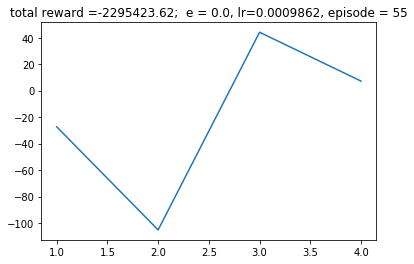

Waiting to train the whole dataset
DONE, lets roll!!
151.243
More than 80 on candle 775
More than 80 on candle 1321


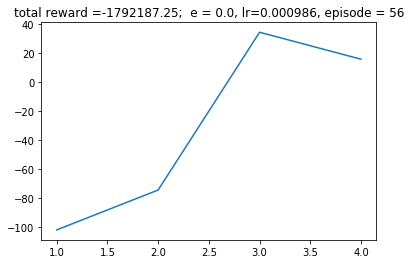

Waiting to train the whole dataset
DONE, lets roll!!
150.992
More than 80 on candle 566
More than 80 on candle 841


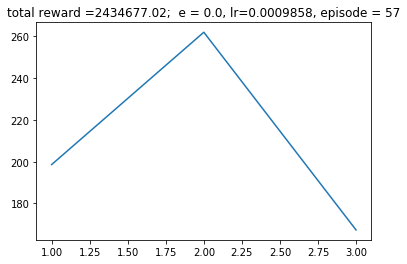

Waiting to train the whole dataset
DONE, lets roll!!
152.932
More than 80 on candle 816
More than 80 on candle 1346


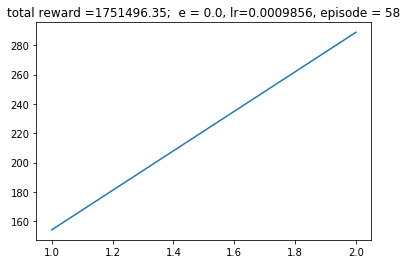

Waiting to train the whole dataset
DONE, lets roll!!
151.988
More than 80 on candle 554
More than 80 on candle 836


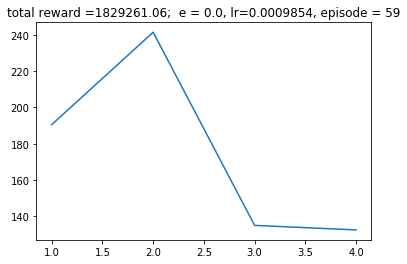

Waiting to train the whole dataset
DONE, lets roll!!
152.056
More than 80 on candle 270
More than 80 on candle 811
More than 80 on candle 1180


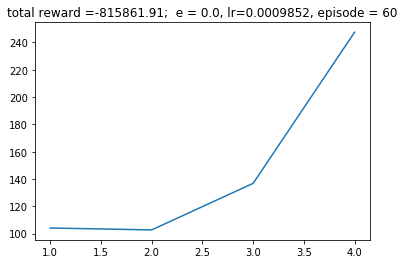

Waiting to train the whole dataset
DONE, lets roll!!
151.579
More than 80 on candle 550
More than 80 on candle 845


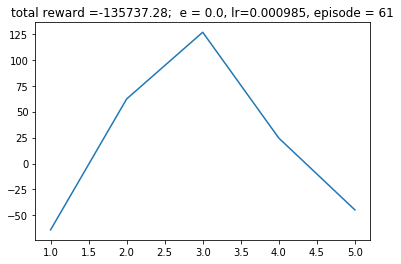

Waiting to train the whole dataset
DONE, lets roll!!
151.585
More than 80 on candle 201
More than 80 on candle 548
More than 80 on candle 1164
More than 80 on candle 1880


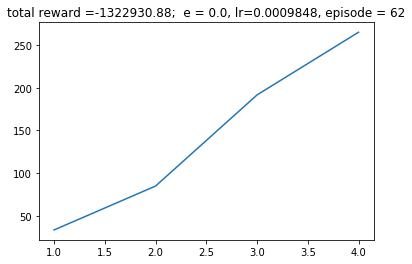

Waiting to train the whole dataset
DONE, lets roll!!
152.885
More than 80 on candle 1405


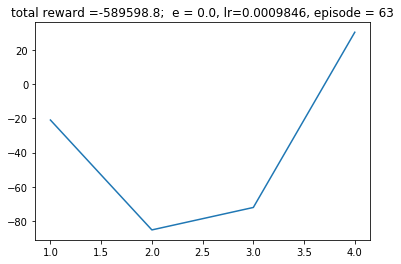

Waiting to train the whole dataset
DONE, lets roll!!
151.059


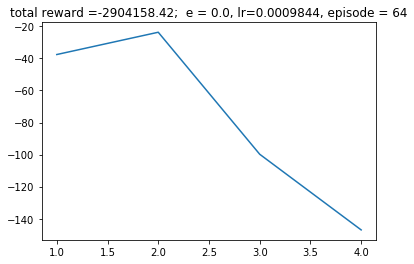

Waiting to train the whole dataset
DONE, lets roll!!
151.566
More than 80 on candle 1035


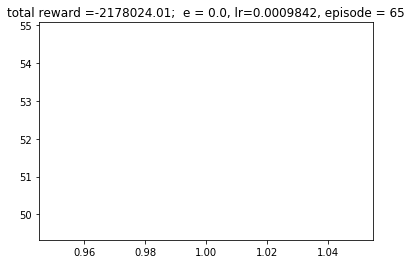

Waiting to train the whole dataset
DONE, lets roll!!
150.141
More than 80 on candle 905
More than 80 on candle 1370


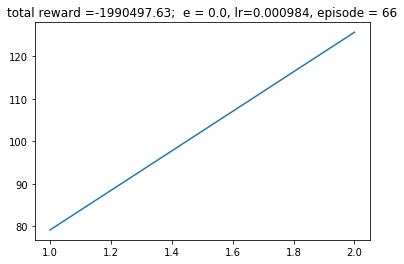

Waiting to train the whole dataset
DONE, lets roll!!
150.166
More than 80 on candle 611
More than 80 on candle 970
More than 80 on candle 1730


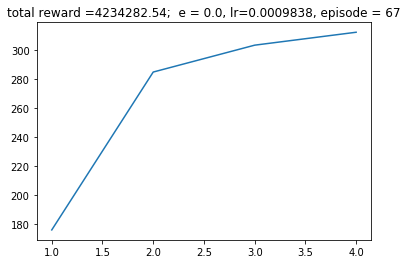

Waiting to train the whole dataset
DONE, lets roll!!
150.227
More than 80 on candle 180
More than 80 on candle 748
More than 80 on candle 1059


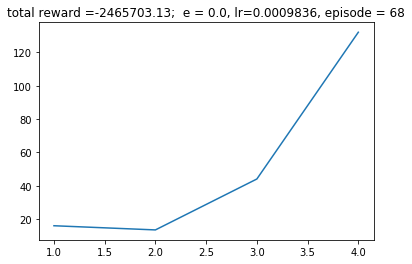

Waiting to train the whole dataset
DONE, lets roll!!
150.591
More than 80 on candle 585
More than 80 on candle 847


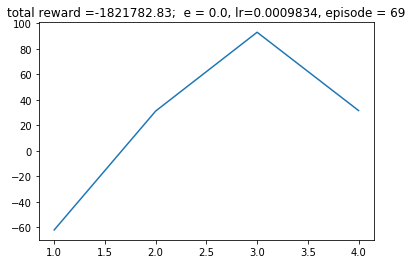

Waiting to train the whole dataset
DONE, lets roll!!
151.432
More than 80 on candle 588
More than 80 on candle 957


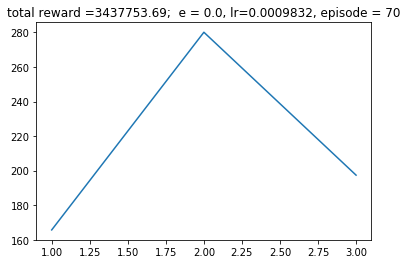

Waiting to train the whole dataset
DONE, lets roll!!
150.388
More than 80 on candle 776


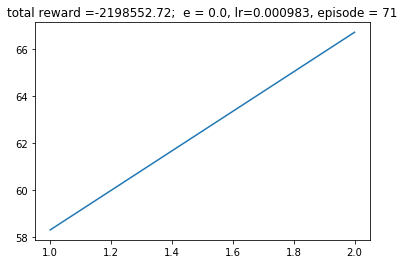

Waiting to train the whole dataset
DONE, lets roll!!
151.125
More than 80 on candle 216


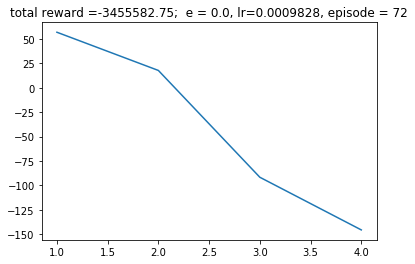

Waiting to train the whole dataset
DONE, lets roll!!
150.367
More than 80 on candle 1088


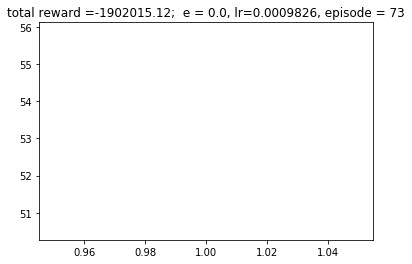

Waiting to train the whole dataset
DONE, lets roll!!
150.2
More than 80 on candle 840
More than 80 on candle 1292


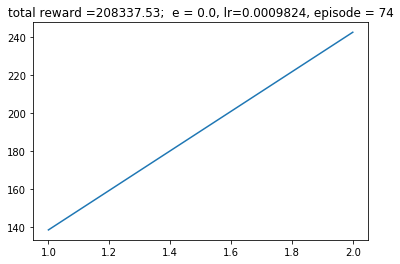

Waiting to train the whole dataset
DONE, lets roll!!
150.345
More than 80 on candle 207
More than 80 on candle 599
More than 80 on candle 938


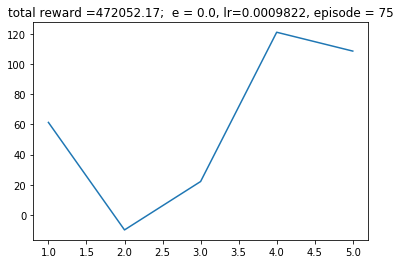

Waiting to train the whole dataset
DONE, lets roll!!
150.357
More than 80 on candle 521
More than 80 on candle 1019


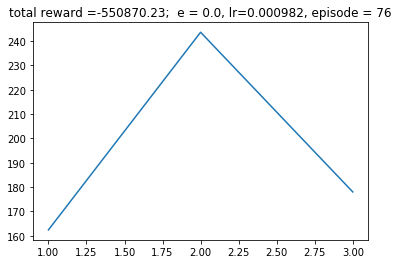

Waiting to train the whole dataset
DONE, lets roll!!
150.937
More than 80 on candle 844
More than 80 on candle 1168


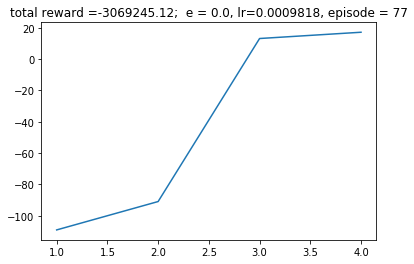

Waiting to train the whole dataset
DONE, lets roll!!
149.994
More than 80 on candle 547
More than 80 on candle 989


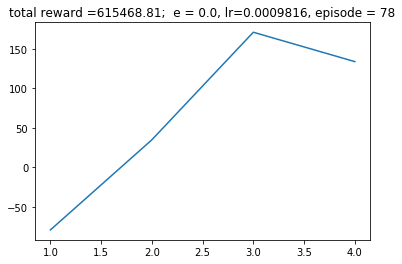

Waiting to train the whole dataset
DONE, lets roll!!
149.976
More than 80 on candle 1071


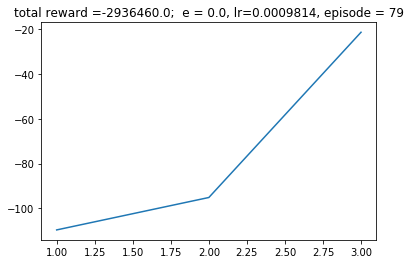

Waiting to train the whole dataset
DONE, lets roll!!
162.455
More than 80 on candle 736
More than 80 on candle 1186


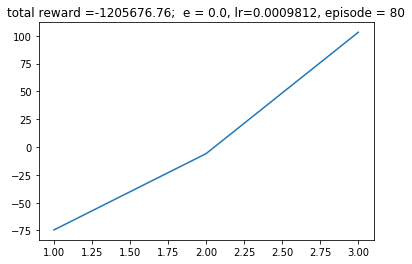

Waiting to train the whole dataset
DONE, lets roll!!
150.312
More than 80 on candle 576
More than 80 on candle 837


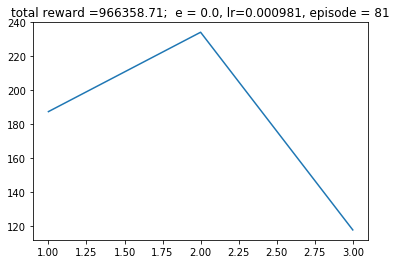

Waiting to train the whole dataset
DONE, lets roll!!
150.929
More than 80 on candle 618
More than 80 on candle 1049


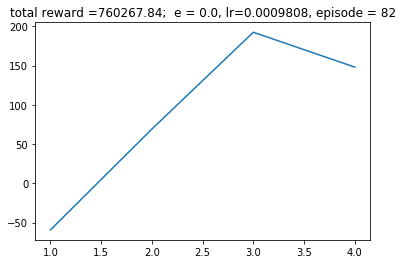

Waiting to train the whole dataset
DONE, lets roll!!
151.016


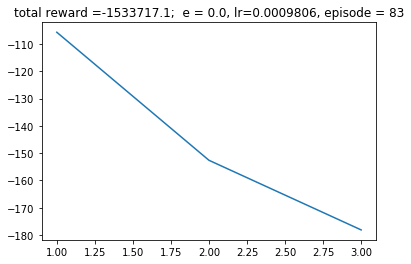

Waiting to train the whole dataset
DONE, lets roll!!
151.755
More than 80 on candle 952
More than 80 on candle 1497
More than 80 on candle 1582
More than 80 on candle 1637
More than 80 on candle 1906


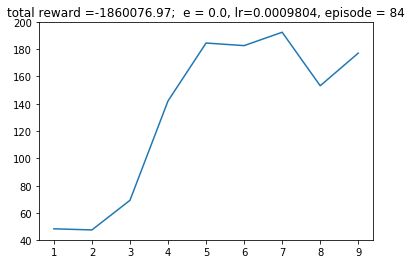

Waiting to train the whole dataset
DONE, lets roll!!
150.189
More than 80 on candle 560
More than 80 on candle 1003


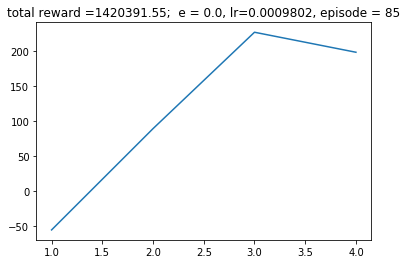

Waiting to train the whole dataset
DONE, lets roll!!
150.032
More than 80 on candle 1420


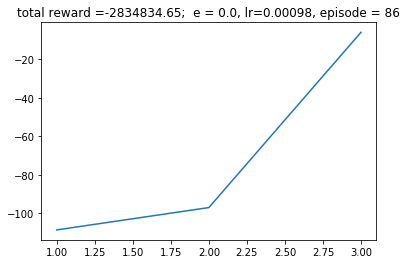

Waiting to train the whole dataset
DONE, lets roll!!
149.771
More than 80 on candle 616
More than 80 on candle 1035
More than 80 on candle 1709


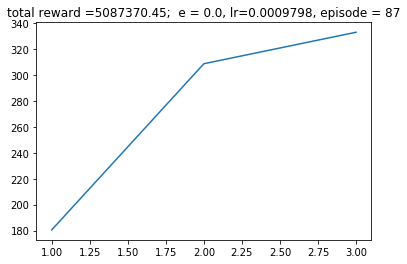

Waiting to train the whole dataset
DONE, lets roll!!
150.071
More than 80 on candle 539
More than 80 on candle 1004


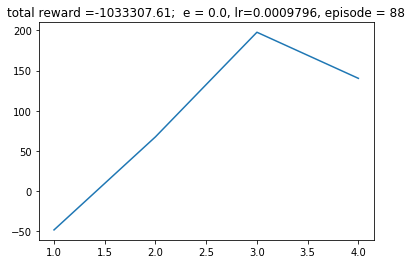

Waiting to train the whole dataset
DONE, lets roll!!
149.621
More than 80 on candle 582
More than 80 on candle 944


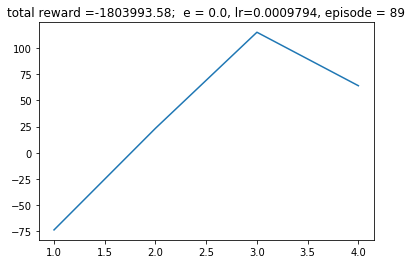

Waiting to train the whole dataset
DONE, lets roll!!
149.818
More than 80 on candle 574
More than 80 on candle 862


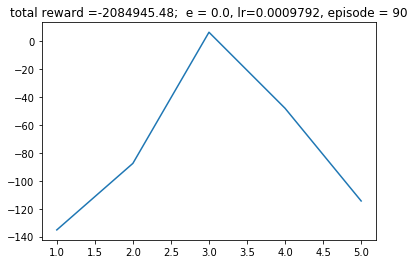

Waiting to train the whole dataset
DONE, lets roll!!
150.14
More than 80 on candle 562


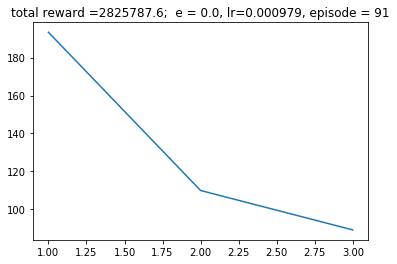

Waiting to train the whole dataset
DONE, lets roll!!
150.015
More than 80 on candle 525


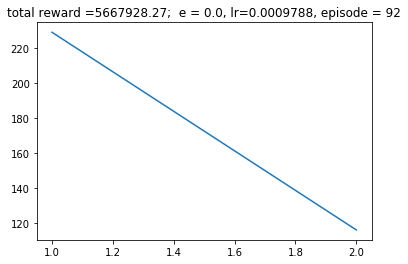

Waiting to train the whole dataset
DONE, lets roll!!
150.286
More than 80 on candle 817


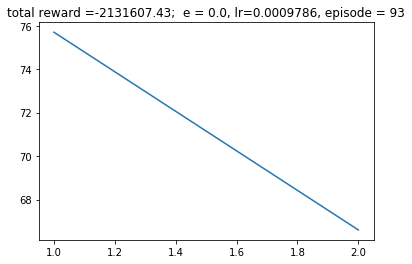

Waiting to train the whole dataset
DONE, lets roll!!
150.665
More than 80 on candle 598
More than 80 on candle 1203


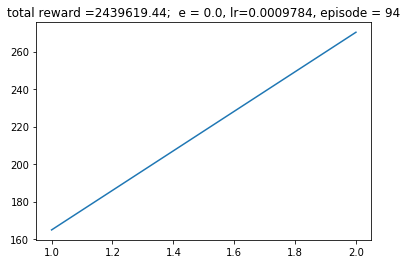

Waiting to train the whole dataset
DONE, lets roll!!
150.64
More than 80 on candle 539
More than 80 on candle 1071
More than 80 on candle 1725


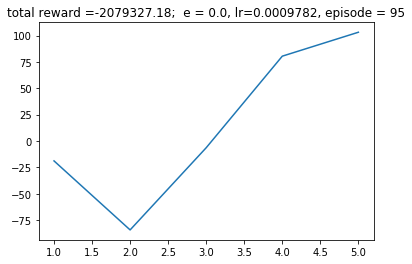

Waiting to train the whole dataset
DONE, lets roll!!
152.11
More than 80 on candle 748
More than 80 on candle 1027


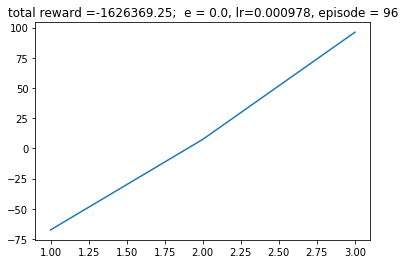

Waiting to train the whole dataset
DONE, lets roll!!
151.033
More than 80 on candle 572
More than 80 on candle 949


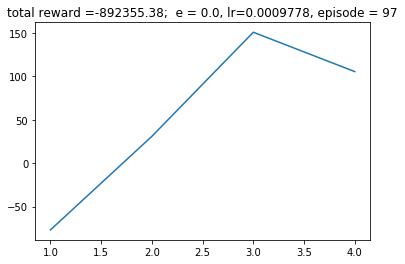

Waiting to train the whole dataset
DONE, lets roll!!
150.194
More than 80 on candle 570
More than 80 on candle 991


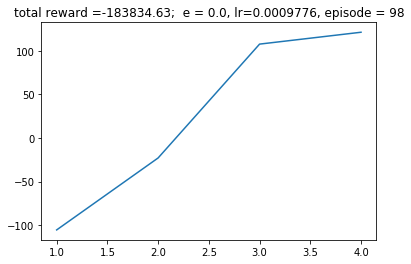

Waiting to train the whole dataset
DONE, lets roll!!
150.421
More than 80 on candle 801
More than 80 on candle 1606


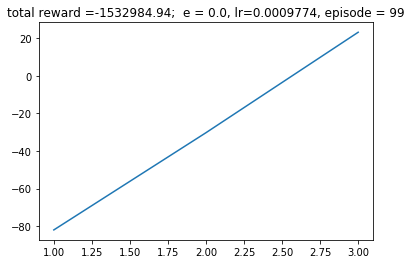

Waiting to train the whole dataset
DONE, lets roll!!
150.47
More than 80 on candle 601
More than 80 on candle 1214


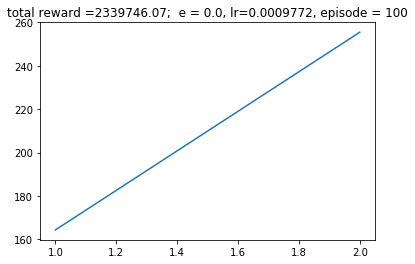

Waiting to train the whole dataset
DONE, lets roll!!
150.348


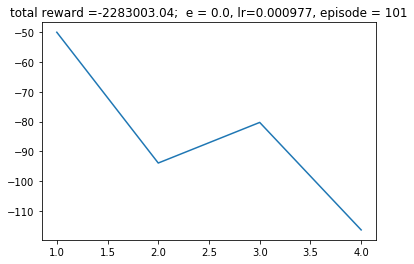

Waiting to train the whole dataset
DONE, lets roll!!
150.165
More than 80 on candle 990
More than 80 on candle 1418


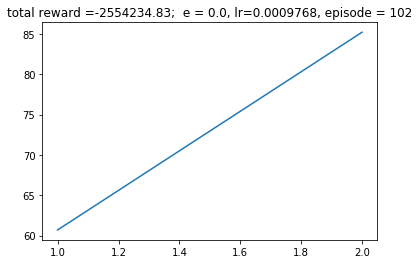

Waiting to train the whole dataset
DONE, lets roll!!
150.206
More than 80 on candle 760
More than 80 on candle 1266


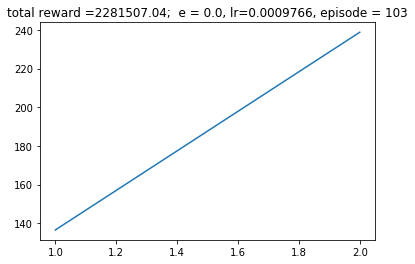

Waiting to train the whole dataset
DONE, lets roll!!
150.067
More than 80 on candle 245


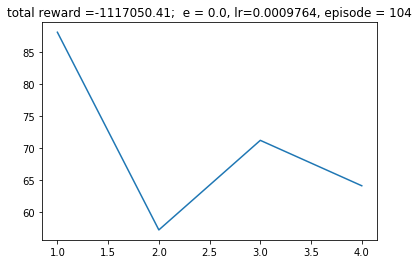

Waiting to train the whole dataset
DONE, lets roll!!
150.806
More than 80 on candle 549
More than 80 on candle 971


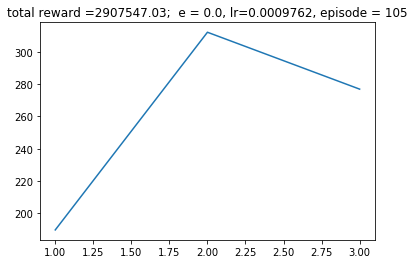

Waiting to train the whole dataset
DONE, lets roll!!
150.111
More than 80 on candle 275
More than 80 on candle 797
More than 80 on candle 1398


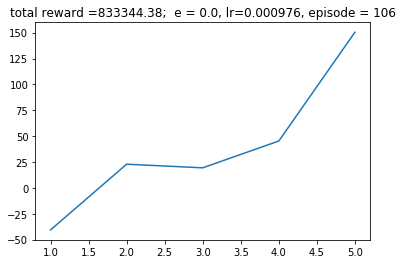

Waiting to train the whole dataset
DONE, lets roll!!
150.618
More than 80 on candle 281
More than 80 on candle 607
More than 80 on candle 1170


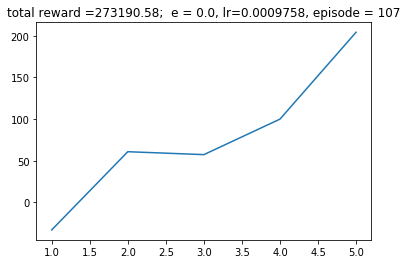

Waiting to train the whole dataset
DONE, lets roll!!
150.149
More than 80 on candle 273
More than 80 on candle 481
More than 80 on candle 737


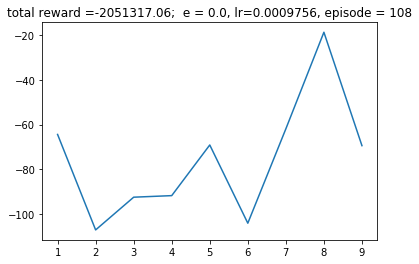

Waiting to train the whole dataset
DONE, lets roll!!
150.404
More than 80 on candle 775
More than 80 on candle 1609


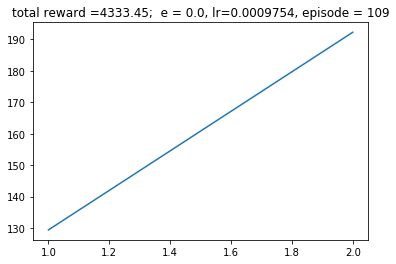

Waiting to train the whole dataset
DONE, lets roll!!
151.128
More than 80 on candle 760
More than 80 on candle 1205


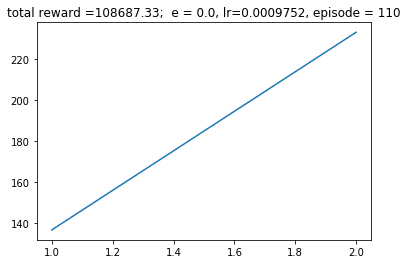

Waiting to train the whole dataset
DONE, lets roll!!
151.454
More than 80 on candle 575
More than 80 on candle 832


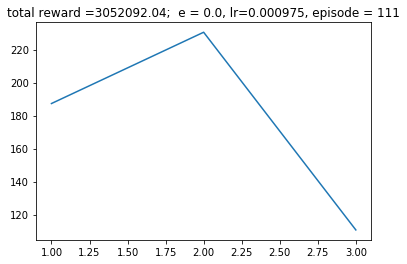

Waiting to train the whole dataset
DONE, lets roll!!
150.202
More than 80 on candle 609


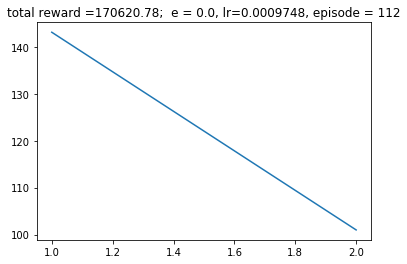

Waiting to train the whole dataset
DONE, lets roll!!
151.649
More than 80 on candle 843
More than 80 on candle 1020


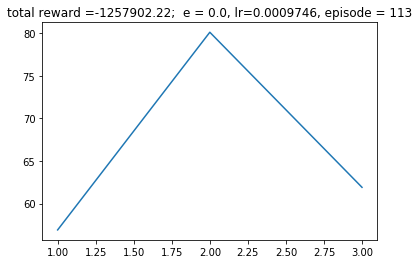

Waiting to train the whole dataset
DONE, lets roll!!
150.432
More than 80 on candle 607
More than 80 on candle 1068
More than 80 on candle 1168
More than 80 on candle 1859


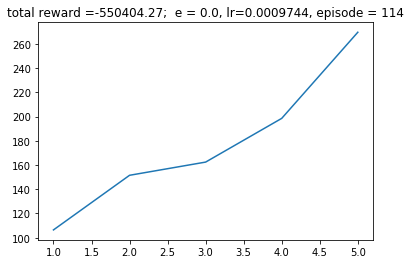

Waiting to train the whole dataset
DONE, lets roll!!
151.908
More than 80 on candle 546
More than 80 on candle 847


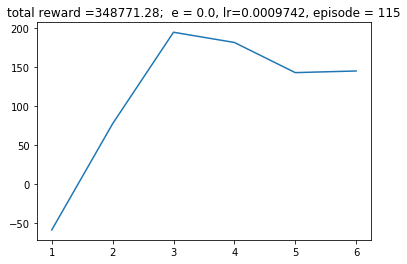

Waiting to train the whole dataset
DONE, lets roll!!
149.338
More than 80 on candle 1077
More than 80 on candle 1433


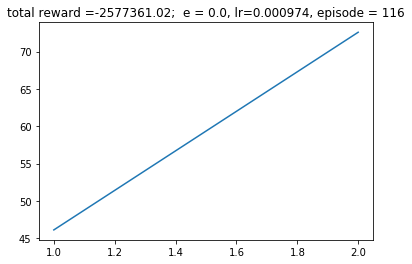

Waiting to train the whole dataset
DONE, lets roll!!
149.462
More than 80 on candle 537
More than 80 on candle 855


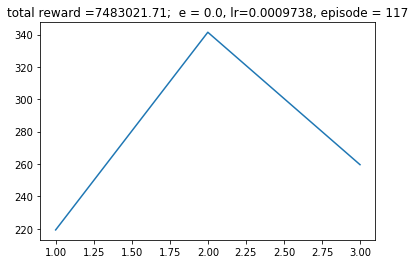

Waiting to train the whole dataset
DONE, lets roll!!
149.515
More than 80 on candle 553


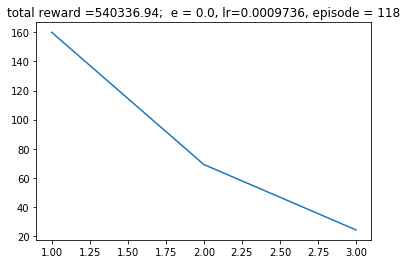

Waiting to train the whole dataset
DONE, lets roll!!
149.513
More than 80 on candle 579


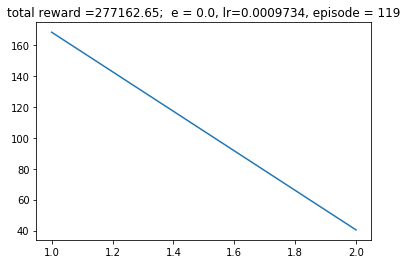

Waiting to train the whole dataset
DONE, lets roll!!
148.983
More than 80 on candle 601


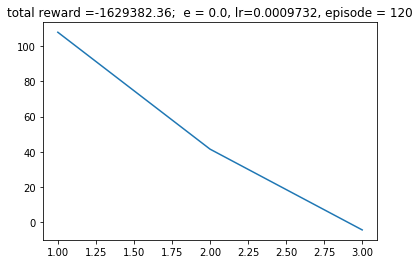

Waiting to train the whole dataset
DONE, lets roll!!
149.378
More than 80 on candle 777
More than 80 on candle 1792


In [ ]:
env = Trevor(Dataframe())
state_size = (NUMBER_OF_SAMPLES, 9)
action_size = 3
batch_size = 32
agent = DQNAgent(state_size, action_size, batch_size)

#agent.save("./save/cartpole-ddqn.h5")
agent.load("./save/cartpole-ddqn.h5")

closed = False
run = False

for e in range(EPISODES):
    state = env.reset()
    strt = t_lib.time()
    
    for time in range(env.df.lenght):
        action, random_action = agent.act(state)

        if action > 3 or action < 0:
            print('Got action ' + action)
            continue

        next_state, reward, closed, _ = env.step(action)

        if not isinstance(next_state, np.ndarray) or not(state, np.ndarray):
            print(next_state)
            print('NOT NUMPY!!')
            continue

        agent.memorize(state=state, action=action, reward=reward, next_state=next_state, done=closed)
        state = next_state
        
        """
        print(f'Actual reward = {round(reward, 1)},\t total reward = {round(env.total_reward, 1)},'
              f'\t action = {action}, \t trade_counter = {round(env.trade_counter, 1)}, '
              f'\t pip_counter = {round(env.closed_counter, 1)}'
              f'\t random_action = {random_action}'
              f'\t candle_number = {time}')
        """
        # print("Actual reward = {}\t, total reward = {},\t action = {}\t trade_counter = {}\t pip_counter = {}".format(round(reward, 1), round(env.total_reward, 1), action, round(env.trade_counter, 1), round(env.closed_counter, 1)))
        if closed and reward > 80 * TIMES_FACTOR:
            agent.update_target_model()
            """
            print("episode: {}/{}, score: {}, e: {}, lr: {}"
                  .format(e, EPISODES, time, round(agent.epsilon, 2)), round(agent.learning_rate, 2))
            """
            print('More than 80 on candle {}'.format(time))
        
        if len(agent.memory) > batch_size:
            # agent.replay(batch_size)
            if not run:
                thr_list = [Thread(target=agent.replay) for _ in range(1)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                    
                thr_list = [Thread(target=agent.train_from_iterations) for _ in range(3)]
                for thr in thr_list:
                    thr.start()
                    t_lib.sleep(1)
                
                run = True
                
    # clear_output()
    env.plot(title='total reward ={};  e = {}, lr={}, episode = {}'.format(round(env.total_reward, 2), round(agent.epsilon, 4), round(agent.learning_rate, 7), e))
    env.reset_closed_list()
    print('Waiting to train the whole dataset')
    while not len(agent.sample_memory) == 0:
        pass
    agent.set_learning_rate()
    print('DONE, lets roll!!')
    agent.save("./save/cartpole-ddqn.h5")
    print(round(t_lib.time() - strt, 3))